In [ ]:
import math
import torch
import time
import random
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.parameter import Parameter
from torch.nn import init
from torch import Tensor
from scipy.special import gamma 
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb}'
custom_params = {
    # Font and text settings
    'font.size': 8,                
    'axes.labelsize': 8,           
    'axes.titlesize': 8,           
    'xtick.labelsize': 8,          
    'ytick.labelsize': 8,          
    'legend.fontsize': 6,          
    
    # Line properties
    'lines.linewidth': 1.2,        
    'lines.markersize': 4,         
    
    # Figure dimensions and quality
    'figure.figsize': (3.5, 2.5),  
    
    # Axis properties
    'axes.linewidth': 0.8,         
    'grid.linewidth': 0.5,         
    'grid.alpha': 0.3,             
}

# Apply the customized parameters to matplotlib
plt.rcParams.update(custom_params)


def MSE(pred,true):
    return np.mean((pred-true)**2)

def MAE(pred, true):
    return np.mean(np.abs(pred-true))

def RMSE(pred,true):
    return np.sqrt(np.mean((pred-true)**2))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def clip_matrix_norm(matrix, max_norm):
    norm = torch.norm(matrix)
    if norm > max_norm:
        matrix = matrix * (max_norm / norm)
    return matrix

In [2]:
class Fractional_Order_Matrix_Differential_Solver_L2(torch.autograd.Function):
    @staticmethod
    def forward(ctx,input1,w,b,alpha,c):
        alpha = torch.tensor(alpha)
        c = torch.tensor(c)
        ctx.save_for_backward(input1,w,b,alpha,c)
        outputs = input1@w + b
        return outputs

    @staticmethod
    def backward(ctx, grad_outputs):
        input1,w,b,alpha,c = ctx.saved_tensors
        x_fractional, w_fractional = Fractional_Order_Matrix_Differential_Solver_L2.Fractional_Order_Matrix_Differential_Linear(input1,w,b,alpha,c)   
        x_grad = grad_outputs@x_fractional
        w_grad = w_fractional@grad_outputs
        b_grad = grad_outputs.sum(dim=0)
        return x_grad, w_grad, b_grad,None,None
          
    @staticmethod
    def Fractional_Order_Matrix_Differential_Linear(xs,ws,b,alpha,c):
        wf = ws[:,0].view(1,-1)
        #main
        w_main = torch.mul(xs,(torch.abs(wf)+1e-8)**(1-alpha)/gamma(2-alpha))
        #partial
        w_partial = torch.mul((xs@wf.T).expand(xs.shape) - torch.mul(xs,wf) + b[0], torch.sgn(wf)*(torch.abs(wf)+1e-8)**(-alpha)/gamma(1-alpha))
        return ws.T, (w_main + clip_matrix_norm(w_partial,c)).transpose(-2,-1)

class FLinear_L2(nn.Module):
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, alpha=0.9, c=1.0, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.c = c
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        return Fractional_Order_Matrix_Differential_Solver_L2.apply(x, self.weight.T, self.bias, self.alpha,self.c)

    def extra_repr(self) -> str:
        return f"in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}"



class Fractional_Order_Matrix_Differential_Solver(torch.autograd.Function):
    @staticmethod
    def forward(ctx,input1,w,b,alpha):
        alpha = torch.tensor(alpha)
        ctx.save_for_backward(input1,w,b,alpha)
        outputs = input1@w + b
        return outputs

    @staticmethod
    def backward(ctx, grad_outputs):
        input1,w,b,alpha = ctx.saved_tensors
        x_fractional, w_fractional = Fractional_Order_Matrix_Differential_Solver.Fractional_Order_Matrix_Differential_Linear(input1,w,b,alpha)   
        x_grad = grad_outputs@x_fractional
        w_grad = w_fractional@grad_outputs
        b_grad = grad_outputs.sum(dim=0)
        return x_grad, w_grad, b_grad,None
          
    @staticmethod
    def Fractional_Order_Matrix_Differential_Linear(xs,ws,b,alpha):
        wf = ws[:,0].view(1,-1)
        #main
        w_main = torch.mul(xs,(torch.abs(wf)+1e-8)**(1-alpha)/gamma(2-alpha))
        #partial
        w_partial = torch.mul((xs@wf.T).expand(xs.shape) - torch.mul(xs,wf) + b[0], torch.sgn(wf)*(torch.abs(wf)+1e-8)**(-alpha)/gamma(1-alpha))
        return ws.T, (w_main + w_partial).transpose(-2,-1)

class FLinear(nn.Module):
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, alpha=0.9, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        return Fractional_Order_Matrix_Differential_Solver.apply(x, self.weight.T, self.bias, self.alpha)

    def extra_repr(self) -> str:
        return f"in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}"

In [80]:
# Configuration parameters
slide_windows_size = 192  # Input sequence length
pred_length = 384        # Prediction horizon length
stock = 'ETTh1'            # Dataset name (ETTm2 for comparison)
features_j = 6           # Target feature index (DJI:4, ETTm2:6)
num_feature = features_j + 1         #(DJI:5, ETTm2:7)

# Load data
df_DJIA = pd.read_csv(r'./data/'+stock+'.csv')
del df_DJIA['date']  # Remove date column

# 1. Split data first (7:1:2 ratio)
def split_time_series(data, train_ratio=0.7, val_ratio=0.1):
    """
    Split time series data in chronological order
    
    Args:
        data: Complete time series data
        train_ratio: Proportion for training set
        val_ratio: Proportion for validation set
    
    Returns:
        train_data, val_data, test_data: Split datasets
    """
    n_samples = len(data)
    train_end = int(n_samples * train_ratio)
    val_end = train_end + int(n_samples * val_ratio)
    
    # Split in chronological order (important for time series)
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    
    return train_data, val_data, test_data

# Split raw data first
train_raw, val_raw, test_raw = split_time_series(df_DJIA.values, 0.7, 0.1)

print(f"Data split results:")
print(f"  Training set: {len(train_raw)} samples ({len(train_raw)/len(df_DJIA)*100:.1f}%)")
print(f"  Validation set: {len(val_raw)} samples ({len(val_raw)/len(df_DJIA)*100:.1f}%)")
print(f"  Test set: {len(test_raw)} samples ({len(test_raw)/len(df_DJIA)*100:.1f}%)")

scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler.fit(train_raw)

# Transform all datasets using training set statistics
train_scaled = scaler.transform(train_raw)
val_scaled = scaler.transform(val_raw)  # Use training set statistics
test_scaled = scaler.transform(test_raw)  # Use training set statistics

# 3. Create sequences for time series forecasting
def create_sequences(data, slide_windows_size, pred_length, target_idx):
    """
    Create input-output sequences for time series forecasting
    
    Args:
        data: Multivariate time series data
        slide_windows_size: Input sequence length (look-back window)
        pred_length: Output sequence length (forecast horizon)
        target_idx: Index of target feature to predict
    
    Returns:
        X: Input sequences [samples, seq_len, features]
        y: Target sequences [samples, pred_length]
    """
    X, y = [], []
    for i in range(len(data) - slide_windows_size - pred_length + 1):
        # Input sequence: sliding window of features
        X.append(data[i:i+slide_windows_size, :])  # [seq_len, features]
        # Target sequence: future values of target feature
        y.append(data[i+slide_windows_size:i+slide_windows_size+pred_length, target_idx])  
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Create sequences for each dataset
X_train, y_train = create_sequences(train_scaled, slide_windows_size, pred_length, features_j)
X_val, y_val = create_sequences(val_scaled, slide_windows_size, pred_length, features_j)
X_test, y_test = create_sequences(test_scaled, slide_windows_size, pred_length, features_j)

print(f"\nSequence creation results:")
print(f"  Training set: X{X_train.shape}, y{y_train.shape}")
print(f"  Validation set: X{X_val.shape}, y{y_val.shape}")
print(f"  Test set: X{X_test.shape}, y{y_test.shape}")

# 4. Convert to PyTorch tensors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print(f"\nTensor shapes:")
print(f"  X_train_tensor: {X_train_tensor.shape}")
print(f"  y_train_tensor: {y_train_tensor.shape}")
print(f"  X_val_tensor: {X_val_tensor.shape}")
print(f"  y_val_tensor: {y_val_tensor.shape}")
print(f"  X_test_tensor: {X_test_tensor.shape}")
print(f"  y_test_tensor: {y_test_tensor.shape}")

Data split results:
  Training set: 12194 samples (70.0%)
  Validation set: 1742 samples (10.0%)
  Test set: 3484 samples (20.0%)

Sequence creation results:
  Training set: X(11619, 192, 7), y(11619, 384)
  Validation set: X(1167, 192, 7), y(1167, 384)
  Test set: X(2909, 192, 7), y(2909, 384)

Using device: cuda:0

Tensor shapes:
  X_train_tensor: torch.Size([11619, 192, 7])
  y_train_tensor: torch.Size([11619, 384])
  X_val_tensor: torch.Size([1167, 192, 7])
  y_val_tensor: torch.Size([1167, 384])
  X_test_tensor: torch.Size([2909, 192, 7])
  y_test_tensor: torch.Size([2909, 384])


In [90]:
alpha = 1.0   ####0.5,0.7,0.9,1.0
c = 1.0
batch_size = 128
num_epochs = 200
set_seed()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=512, hidden_size2=256,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        
        self.linear1 = FLinear(input_size, hidden_size1, alpha)    
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear(hidden_size1, hidden_size2, alpha) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear(hidden_size2, output_size, alpha)  
        
        # self.linear1 = FLinear_L2(input_size, hidden_size1, alpha, c)    
        # self.leakrelu1 = nn.LeakyReLU()                          
        # self.linear2 = FLinear_L2(hidden_size1, hidden_size2, alpha, c) 
        # self.leakrelu2 = nn.LeakyReLU() 
        # self.linear3 = FLinear_L2(hidden_size2, output_size, alpha, c) 
        
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss10_FGD = []    ### 0.5,0.7,0.9,1.0
val_loss10_FGD = []      ### 0.5,0.7,0.9,1.0

lr =2e-2 
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss10_FGD.append(loss_sum.cpu().detach().numpy())     ########### 0.5,0.7,0.9,1.0
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val_tensor)
        MSE_val = MSE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss10_FGD.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9,1.0
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')

alpha = 0.9   ####0.1,0.3,0.5,0.7,0.9,1.0
# batch_size = 16
set_seed()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=512, hidden_size2=256,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear(input_size, hidden_size1, alpha)    
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear(hidden_size1, hidden_size2, alpha) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear(hidden_size2, output_size, alpha)  
        
        # self.linear1 = FLinear_L2(input_size, hidden_size1, alpha, c)    
        # self.leakrelu1 = nn.LeakyReLU()                          
        # self.linear2 = FLinear_L2(hidden_size1, hidden_size2, alpha, c) 
        # self.leakrelu2 = nn.LeakyReLU() 
        # self.linear3 = FLinear_L2(hidden_size2, output_size, alpha, c) 
        
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss09_FGD = []    ### 0.1,0.3,0.5,0.7,0.9,1.0
val_loss09_FGD = []      ### 0.1,0.3,0.5,0.7,0.9,1.0

# lr =1e-1  
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss09_FGD.append(loss_sum.cpu().detach().numpy())     ########### 0.1,0.3,0.5,0.7,0.9,1.0
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val_tensor)
        MSE_val = MSE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss09_FGD.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9,1.0
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')


alpha = 0.7   ####0.1,0.3,0.5,0.7,0.9,1.0
# batch_size = 16
set_seed()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=512, hidden_size2=256,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear(input_size, hidden_size1, alpha)    
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear(hidden_size1, hidden_size2, alpha) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear(hidden_size2, output_size, alpha)  
        
        # self.linear1 = FLinear_L2(input_size, hidden_size1, alpha, c)    
        # self.leakrelu1 = nn.LeakyReLU()                          
        # self.linear2 = FLinear_L2(hidden_size1, hidden_size2, alpha, c) 
        # self.leakrelu2 = nn.LeakyReLU() 
        # self.linear3 = FLinear_L2(hidden_size2, output_size, alpha, c) 
        
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss07_FGD = []    ### 0.1,0.3,0.5,0.7,0.9,1.0
val_loss07_FGD = []      ### 0.1,0.3,0.5,0.7,0.9,1.0

# lr =1e-1  
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss07_FGD.append(loss_sum.cpu().detach().numpy())     ########### 0.1,0.3,0.5,0.7,0.9,1.0
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val_tensor)
        MSE_val = MSE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss07_FGD.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9,1.0
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')


alpha = 0.5   ####0.1,0.3,0.5,0.7,0.9,1.0
# batch_size = 16
set_seed()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=512, hidden_size2=256,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = FLinear(input_size, hidden_size1, alpha)    
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear(hidden_size1, hidden_size2, alpha) 
        self.leakrelu2 = nn.LeakyReLU()
        self.linear3 = FLinear(hidden_size2, output_size, alpha)  
        
        # self.linear1 = FLinear_L2(input_size, hidden_size1, alpha, c)    
        # self.leakrelu1 = nn.LeakyReLU()                          
        # self.linear2 = FLinear_L2(hidden_size1, hidden_size2, alpha, c) 
        # self.leakrelu2 = nn.LeakyReLU() 
        # self.linear3 = FLinear_L2(hidden_size2, output_size, alpha, c) 
        
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss05_FGD = []    ### 0.1,0.3,0.5,0.7,0.9,1.0
val_loss05_FGD = []      ### 0.1,0.3,0.5,0.7,0.9,1.0

# lr =1e-1  
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss05_FGD.append(loss_sum.cpu().detach().numpy())     ########### 0.1,0.3,0.5,0.7,0.9,1.0
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val_tensor)
        MSE_val = MSE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss05_FGD.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9,1.0
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')

Epoch 1/200, Train Loss: 15.7750
Epoch 1/200, Val Loss: 0.0203

Epoch 2/200, Train Loss: 12.1297
Epoch 2/200, Val Loss: 0.0219

Epoch 3/200, Train Loss: 6.7759
Epoch 3/200, Val Loss: 0.0443

Epoch 4/200, Train Loss: 3.1139
Epoch 4/200, Val Loss: 0.0606

Epoch 5/200, Train Loss: 1.9019
Epoch 5/200, Val Loss: 0.0634

Epoch 6/200, Train Loss: 1.5925
Epoch 6/200, Val Loss: 0.0639

Epoch 7/200, Train Loss: 1.5006
Epoch 7/200, Val Loss: 0.0648

Epoch 8/200, Train Loss: 1.4594
Epoch 8/200, Val Loss: 0.0617

Epoch 9/200, Train Loss: 1.4273
Epoch 9/200, Val Loss: 0.0605

Epoch 10/200, Train Loss: 1.3998
Epoch 10/200, Val Loss: 0.0592

Epoch 11/200, Train Loss: 1.3727
Epoch 11/200, Val Loss: 0.0571

Epoch 12/200, Train Loss: 1.3478
Epoch 12/200, Val Loss: 0.0560

Epoch 13/200, Train Loss: 1.3215
Epoch 13/200, Val Loss: 0.0540

Epoch 14/200, Train Loss: 1.2965
Epoch 14/200, Val Loss: 0.0539

Epoch 15/200, Train Loss: 1.2703
Epoch 15/200, Val Loss: 0.0523

Epoch 16/200, Train Loss: 1.2459
Epoch 16

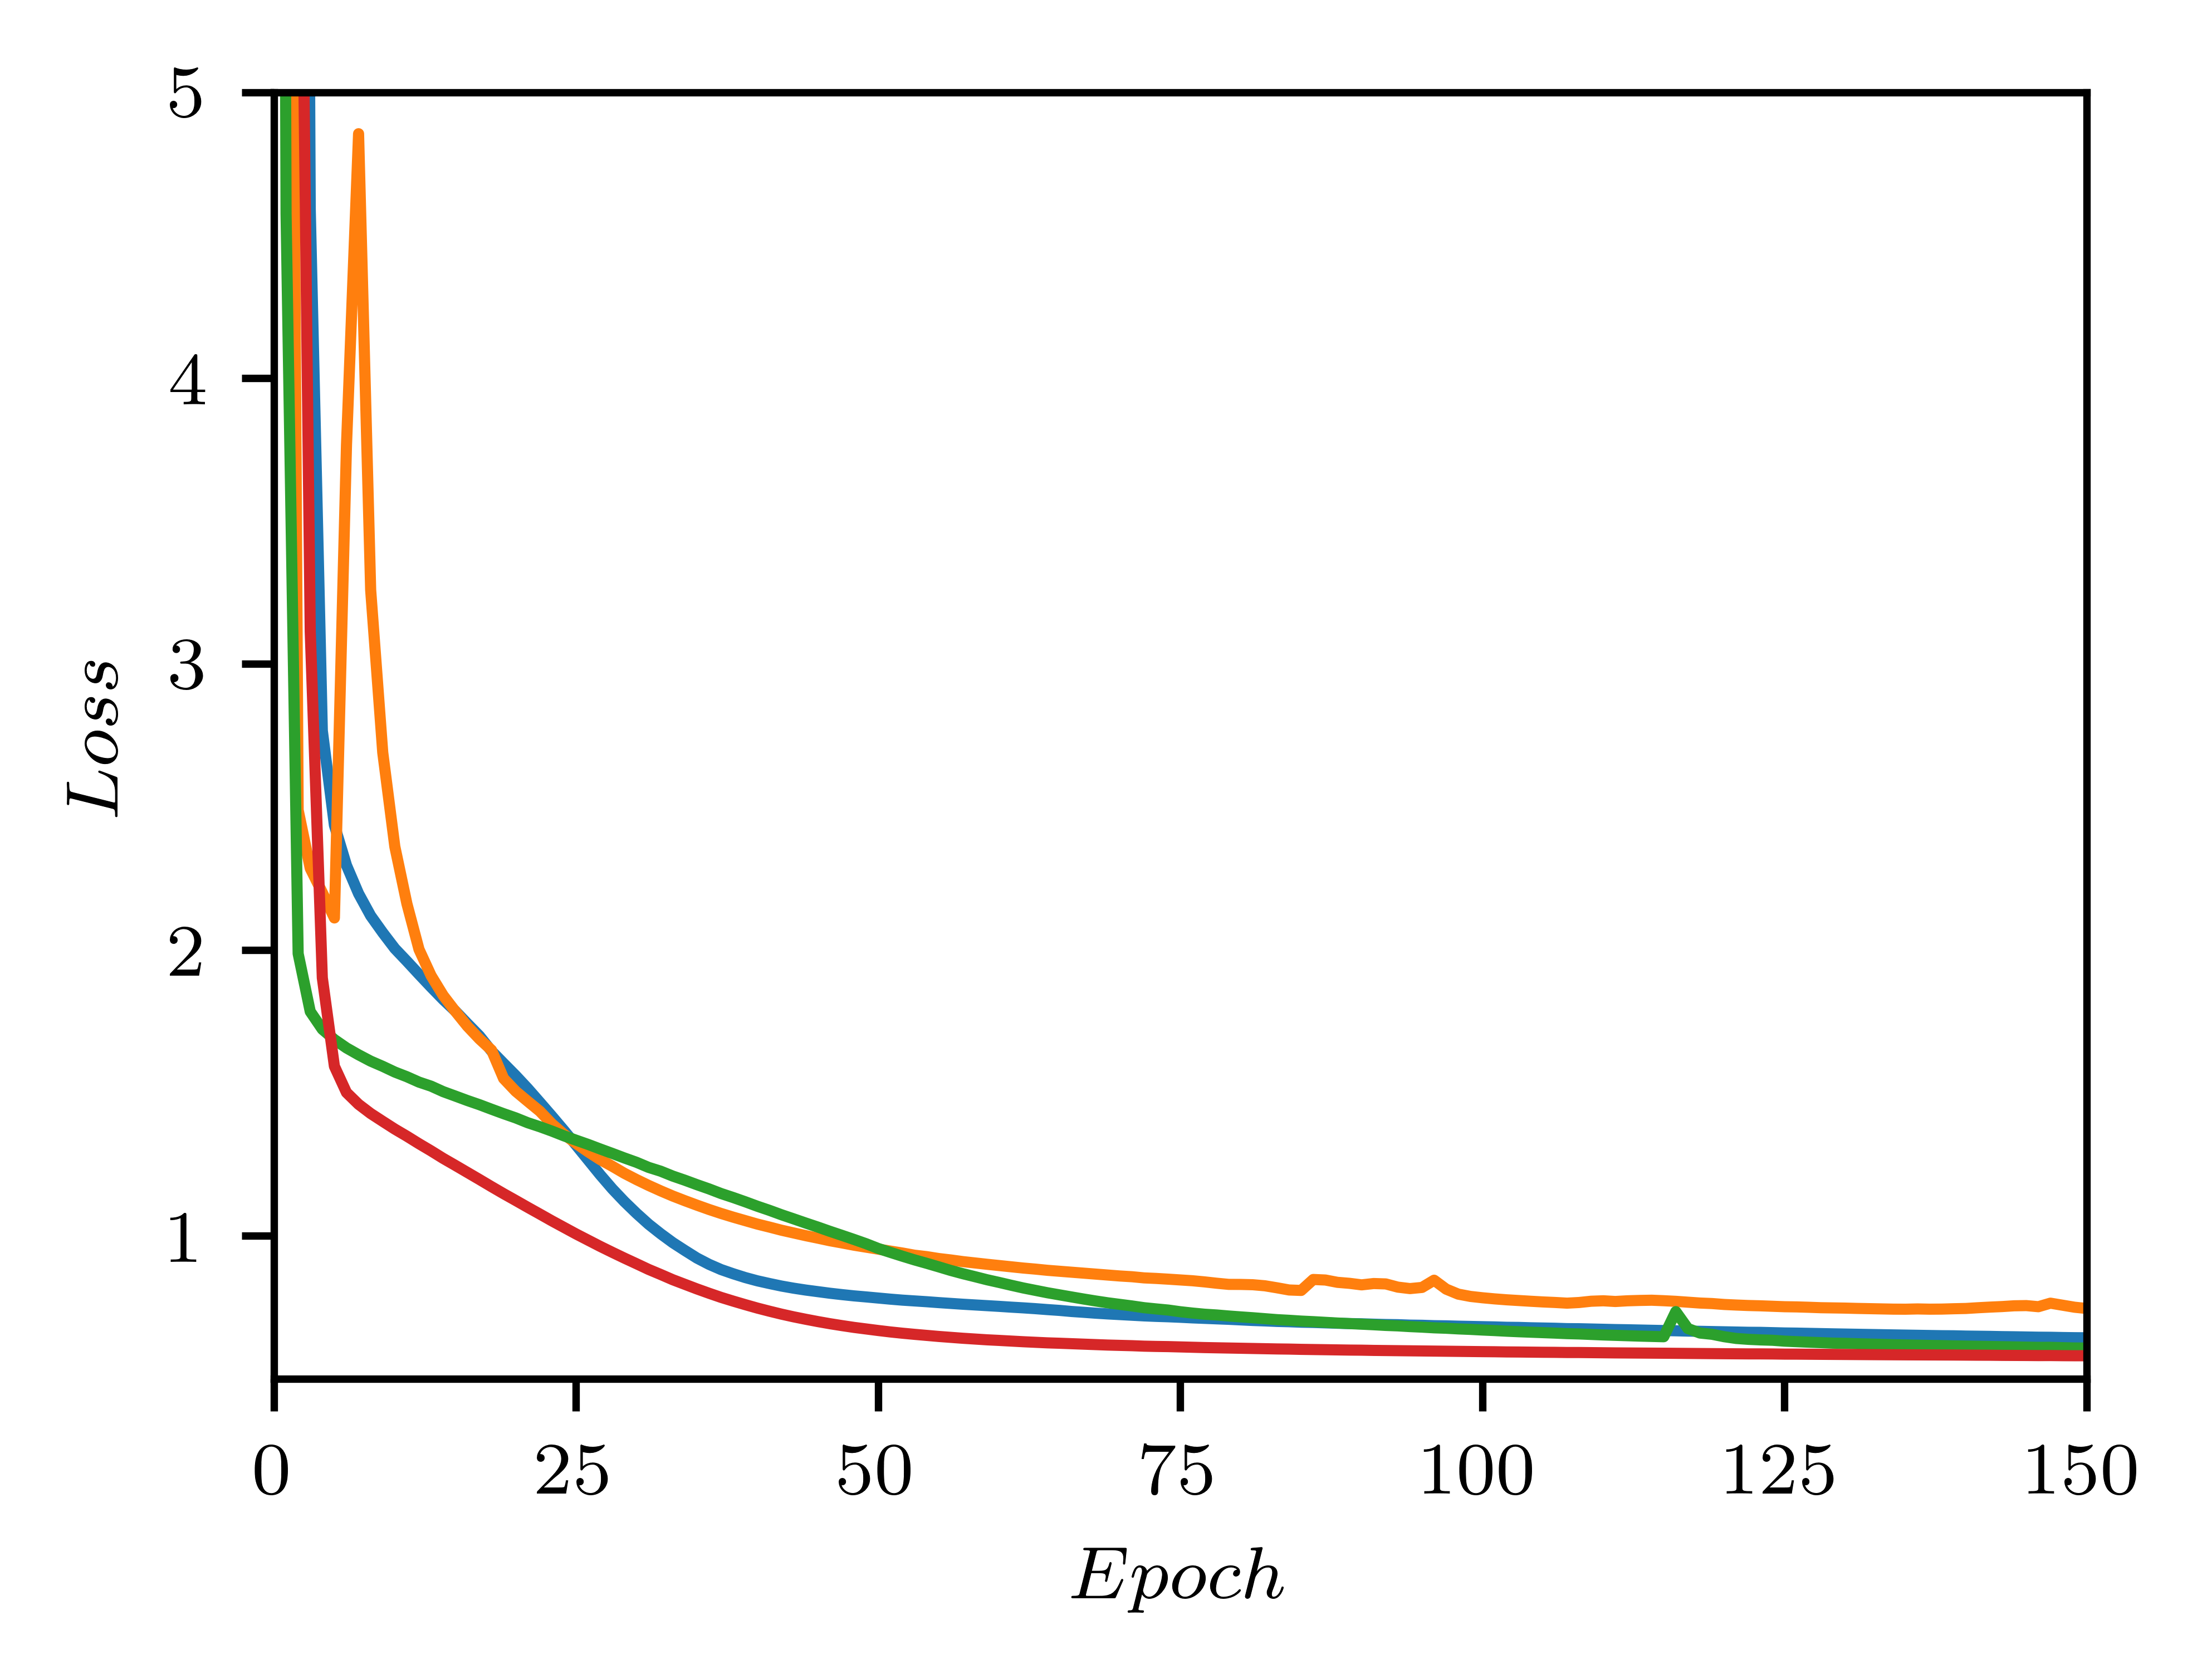

In [ ]:
plt.figure(figsize=(3.5,2.5),dpi=1200)
plt.plot(train_loss05_FGD, label=r'$\alpha=0.5$', color='#1F77B4')  # blue
plt.plot(train_loss07_FGD, label=r'$\alpha=0.7$', color='#FF7F0E')  # orange
plt.plot(train_loss09_FGD, label=r'$\alpha=0.9$', color='#2CA02C')  # green
plt.plot(train_loss10_FGD, label=r'$\alpha=1.0$', color='#D62728')  # red
plt.xlim(0,150)
plt.xticks([0, 25, 50, 75, 100, 125, 150]) 
plt.ylim(0.5,5)
plt.xlabel('$Epoch$')
plt.ylabel('$Loss$')
# plt.legend()

plt.savefig('picture/fig4-5/FGD'+'min-max'+'_'+str(batch_size)+'_'+str(lr)+str(stock)+'.svg',bbox_inches='tight',format='svg')
plt.savefig('picture/fig4-5/FGD'+'min-max'+'_'+str(batch_size)+'_'+str(lr)+str(stock)+'.pdf',bbox_inches='tight',format='pdf')

plt.show()

In [92]:
alpha = 1.0   ####0.5,0.7,0.9,1.0
c = 1.0
# batch_size = 256
# num_epochs = 200
set_seed()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=512, hidden_size2=256,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        
        # self.linear1 = FLinear(input_size, hidden_size1, alpha)    
        # self.leakrelu1 = nn.LeakyReLU()                          
        # self.linear2 = FLinear(hidden_size1, hidden_size2, alpha) 
        # self.leakrelu2 = nn.LeakyReLU()
        # self.linear3 = FLinear(hidden_size2, output_size, alpha)  
        
        self.linear1 = FLinear_L2(input_size, hidden_size1, alpha, c)    
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear_L2(hidden_size1, hidden_size2, alpha, c) 
        self.leakrelu2 = nn.LeakyReLU() 
        self.linear3 = FLinear_L2(hidden_size2, output_size, alpha, c) 
        
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss10_FGD_L2 = []    ### 0.1,0.3,0.5,0.7,0.9,1.0
val_loss10_FGD_L2 = []      ### 0.1,0.3,0.5,0.7,0.9,1.0

# lr =3e-2 
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss10_FGD_L2.append(loss_sum.cpu().detach().numpy())     ########### 0.1,0.3,0.5,0.7,0.9,1.0
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val_tensor)
        MSE_val = MSE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss10_FGD_L2.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9,1.0
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')

alpha = 0.9   ####0.1,0.3,0.5,0.7,0.9,1.0
# batch_size = 16
set_seed()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=512, hidden_size2=256,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        # self.linear1 = FLinear(input_size, hidden_size1, alpha)    
        # self.leakrelu1 = nn.LeakyReLU()                          
        # self.linear2 = FLinear(hidden_size1, hidden_size2, alpha) 
        # self.leakrelu2 = nn.LeakyReLU()
        # self.linear3 = FLinear(hidden_size2, output_size, alpha)  
        
        self.linear1 = FLinear_L2(input_size, hidden_size1, alpha, c)    
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear_L2(hidden_size1, hidden_size2, alpha, c) 
        self.leakrelu2 = nn.LeakyReLU() 
        self.linear3 = FLinear_L2(hidden_size2, output_size, alpha, c) 
        
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss09_FGD_L2 = []    ### 0.1,0.3,0.5,0.7,0.9,1.0
val_loss09_FGD_L2 = []      ### 0.1,0.3,0.5,0.7,0.9,1.0

# lr =1e-1  
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss09_FGD_L2.append(loss_sum.cpu().detach().numpy())     ########### 0.1,0.3,0.5,0.7,0.9,1.0
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val_tensor)
        MSE_val = MSE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss09_FGD_L2.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9,1.0
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')

alpha = 0.7   ####0.1,0.3,0.5,0.7,0.9,1.0
# batch_size = 16
set_seed()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=512, hidden_size2=256,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        # self.linear1 = FLinear(input_size, hidden_size1, alpha)    
        # self.leakrelu1 = nn.LeakyReLU()                          
        # self.linear2 = FLinear(hidden_size1, hidden_size2, alpha) 
        # self.leakrelu2 = nn.LeakyReLU()
        # self.linear3 = FLinear(hidden_size2, output_size, alpha)  
        
        self.linear1 = FLinear_L2(input_size, hidden_size1, alpha, c)    
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear_L2(hidden_size1, hidden_size2, alpha, c) 
        self.leakrelu2 = nn.LeakyReLU() 
        self.linear3 = FLinear_L2(hidden_size2, output_size, alpha, c) 
        
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss07_FGD_L2 = []    ### 0.1,0.3,0.5,0.7,0.9,1.0
val_loss07_FGD_L2 = []      ### 0.1,0.3,0.5,0.7,0.9,1.0

# lr =1e-1  
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss07_FGD_L2.append(loss_sum.cpu().detach().numpy())     ########### 0.1,0.3,0.5,0.7,0.9,1.0
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val_tensor)
        MSE_val = MSE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss07_FGD_L2.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9,1.0
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')

alpha = 0.5   ####0.1,0.3,0.5,0.7,0.9,1.0
# batch_size = 16
set_seed()
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1=512, hidden_size2=256,output_size=pred_length):  
        super().__init__()
        self.flatten = nn.Flatten()
        # self.linear1 = FLinear(input_size, hidden_size1, alpha)    
        # self.leakrelu1 = nn.LeakyReLU()                          
        # self.linear2 = FLinear(hidden_size1, hidden_size2, alpha) 
        # self.leakrelu2 = nn.LeakyReLU()
        # self.linear3 = FLinear(hidden_size2, output_size, alpha)  
        
        self.linear1 = FLinear_L2(input_size, hidden_size1, alpha, c)    
        self.leakrelu1 = nn.LeakyReLU()                          
        self.linear2 = FLinear_L2(hidden_size1, hidden_size2, alpha, c) 
        self.leakrelu2 = nn.LeakyReLU() 
        self.linear3 = FLinear_L2(hidden_size2, output_size, alpha, c) 
        
    def forward(self, x):
        x = self.flatten(x)    # (batch_size, seq_len*num_features)
        x = self.leakrelu1(self.linear1(x))
        x = self.leakrelu2(self.linear2(x))
        x = self.linear3(x)
        return x


set_seed()
model = MLP(input_size=slide_windows_size*num_feature).to(device)

train_loss05_FGD_L2 = []    ### 0.1,0.3,0.5,0.7,0.9,1.0
val_loss05_FGD_L2 = []      ### 0.1,0.3,0.5,0.7,0.9,1.0

# lr =1e-1  
best_loss = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for ii in range(num_epochs):
    model.train()
    loss_sum = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_sum += loss
        loss.backward()   #The default value of retain_graph is False.
        optimizer.step()
    train_loss05_FGD_L2.append(loss_sum.cpu().detach().numpy())     ########### 0.1,0.3,0.5,0.7,0.9,1.0
    
    print(f"Epoch {ii + 1}/{num_epochs}, Train Loss: {loss_sum.cpu().detach().numpy():.4f}")
        
    model.eval()
    with torch.no_grad():
        Val_outputs = model(X_val_tensor)
        MSE_val = MSE(y_val_tensor.cpu().detach().numpy(),Val_outputs.cpu().detach().numpy())
        
        val_loss05_FGD_L2.append(MSE_val)   ########################Validation_loss 0.1,0.3,0.5,0.7,0.9,1.0
        
        print(f"Epoch {ii + 1}/{num_epochs}, Val Loss: {MSE_val:.4f}")
        print('')

Epoch 1/200, Train Loss: 15.7750
Epoch 1/200, Val Loss: 0.0203

Epoch 2/200, Train Loss: 12.1297
Epoch 2/200, Val Loss: 0.0219

Epoch 3/200, Train Loss: 6.7759
Epoch 3/200, Val Loss: 0.0443

Epoch 4/200, Train Loss: 3.1139
Epoch 4/200, Val Loss: 0.0606

Epoch 5/200, Train Loss: 1.9019
Epoch 5/200, Val Loss: 0.0634

Epoch 6/200, Train Loss: 1.5925
Epoch 6/200, Val Loss: 0.0639

Epoch 7/200, Train Loss: 1.5006
Epoch 7/200, Val Loss: 0.0648

Epoch 8/200, Train Loss: 1.4594
Epoch 8/200, Val Loss: 0.0617

Epoch 9/200, Train Loss: 1.4273
Epoch 9/200, Val Loss: 0.0605

Epoch 10/200, Train Loss: 1.3998
Epoch 10/200, Val Loss: 0.0592

Epoch 11/200, Train Loss: 1.3727
Epoch 11/200, Val Loss: 0.0571

Epoch 12/200, Train Loss: 1.3478
Epoch 12/200, Val Loss: 0.0560

Epoch 13/200, Train Loss: 1.3215
Epoch 13/200, Val Loss: 0.0540

Epoch 14/200, Train Loss: 1.2965
Epoch 14/200, Val Loss: 0.0539

Epoch 15/200, Train Loss: 1.2703
Epoch 15/200, Val Loss: 0.0523

Epoch 16/200, Train Loss: 1.2459
Epoch 16

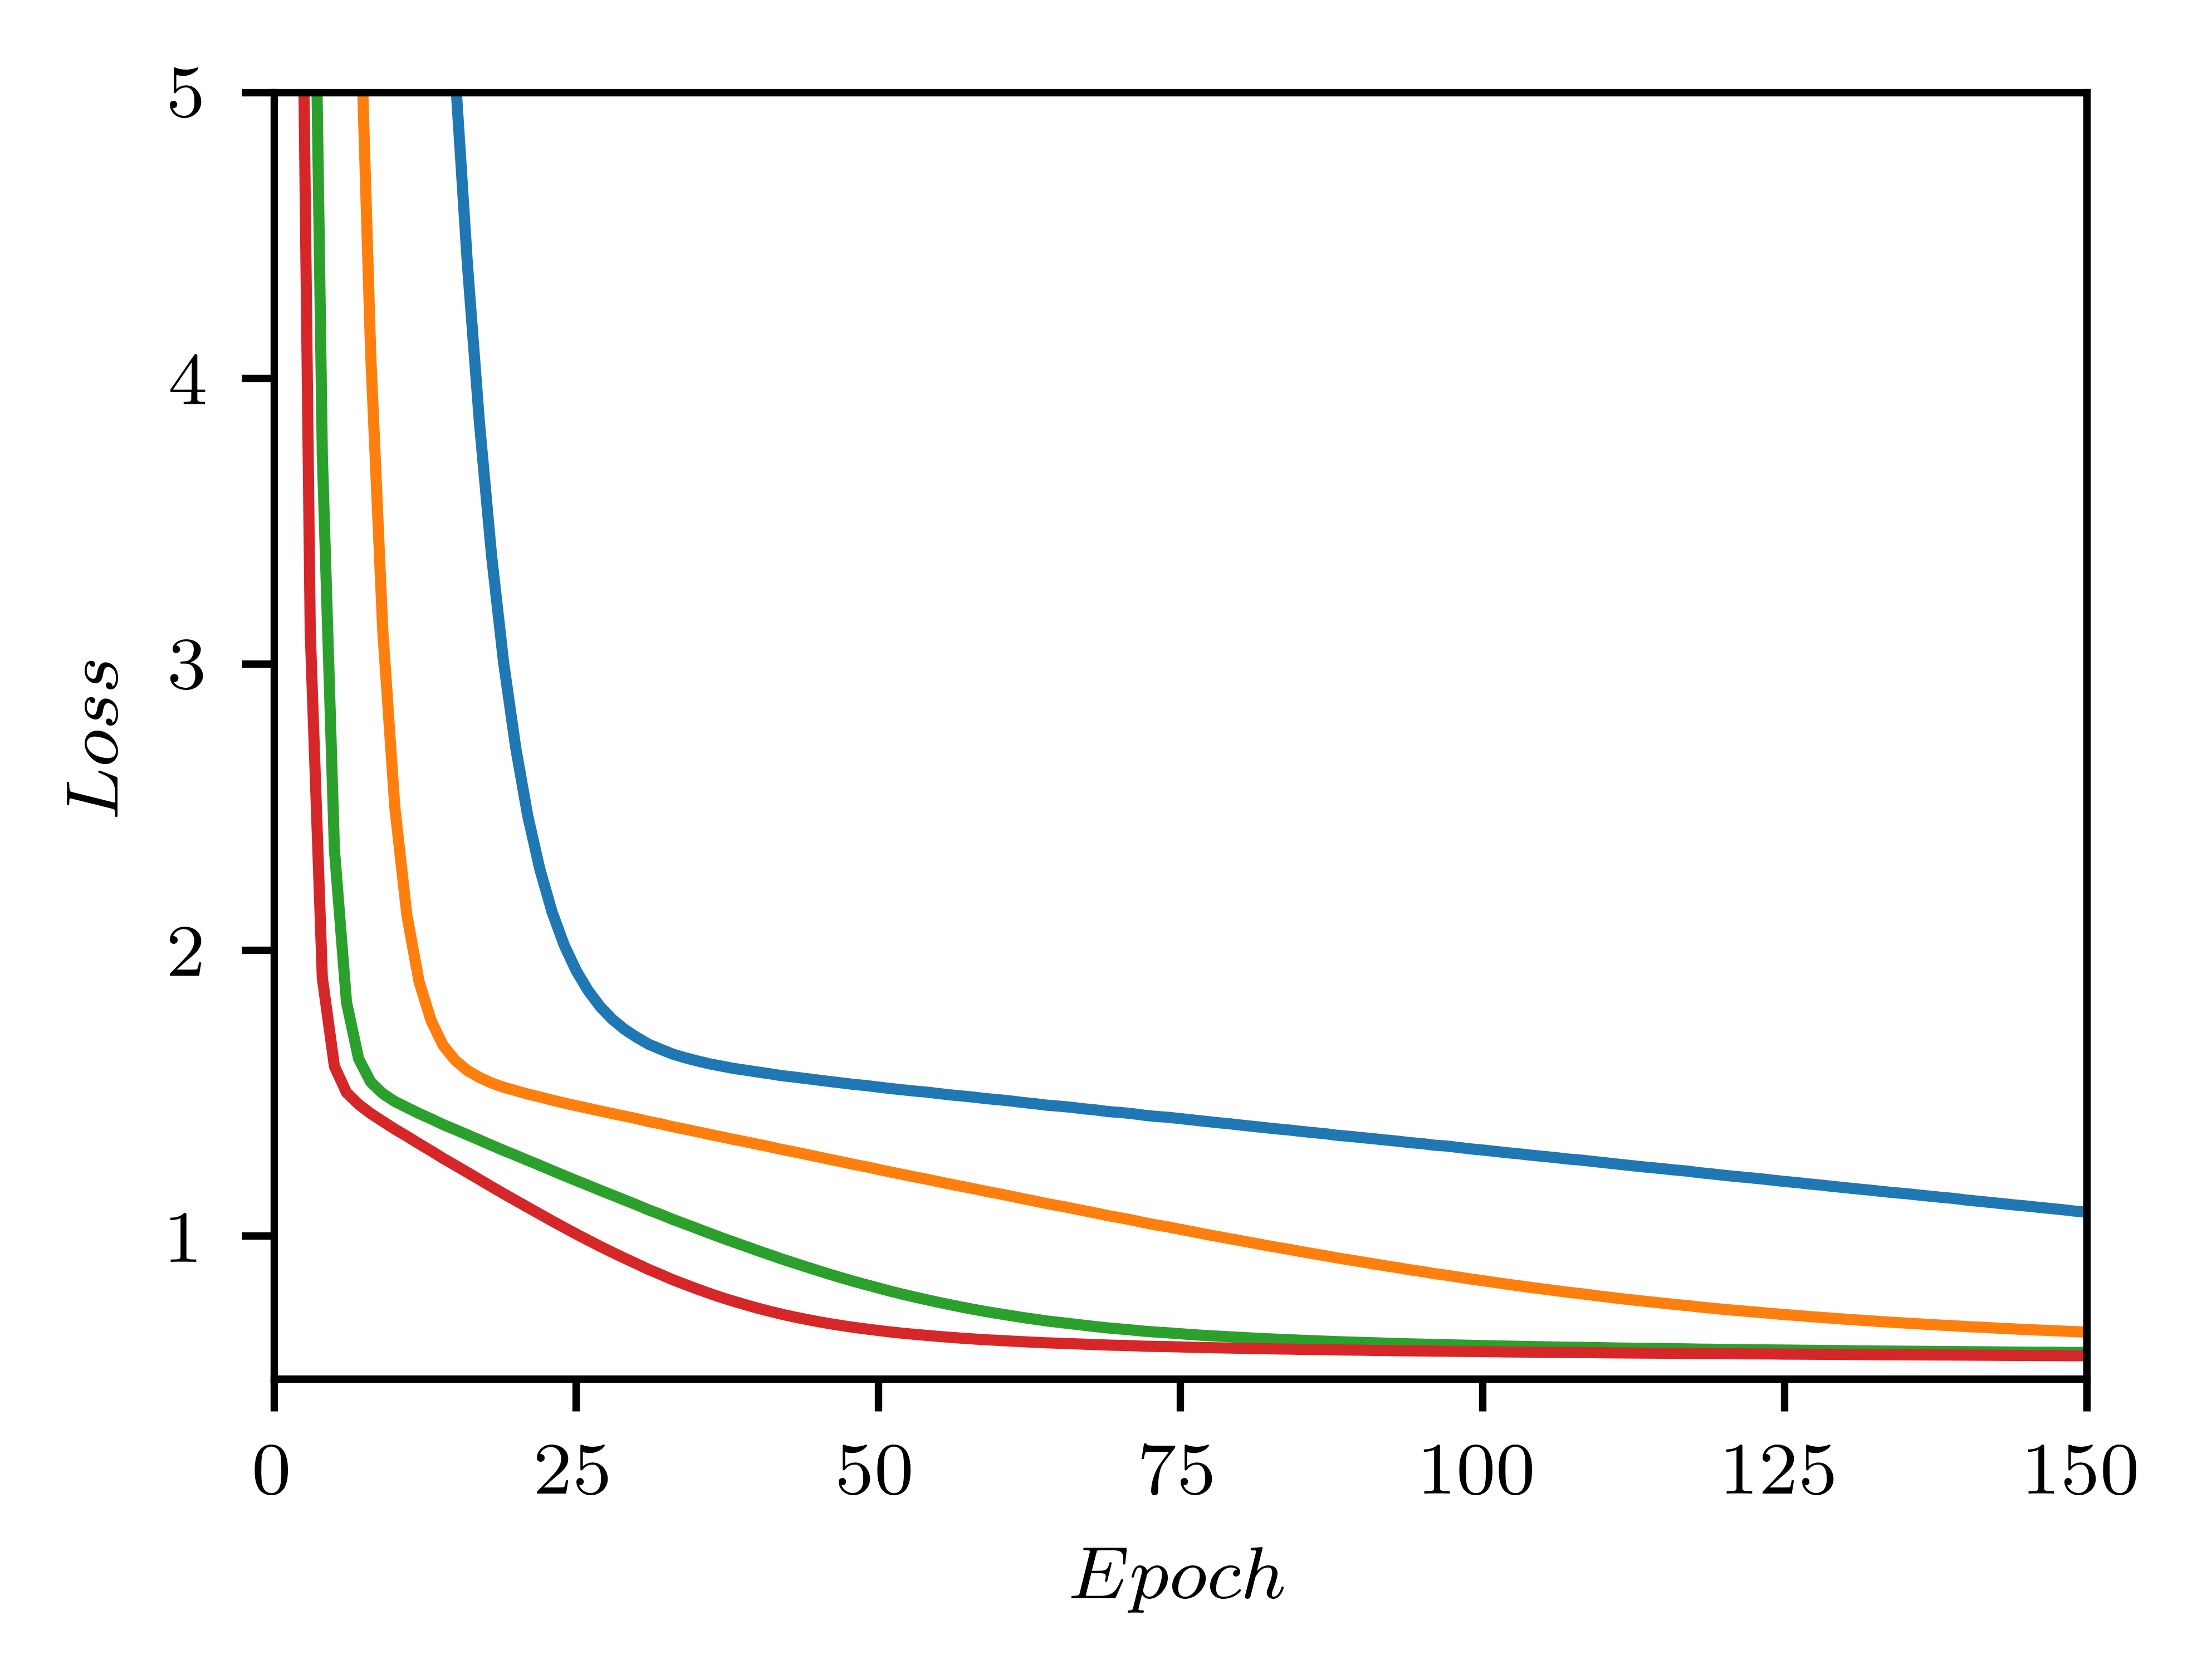

In [ ]:
plt.figure(figsize=(3.5,2.5),dpi=1200)
plt.plot(train_loss05_FGD_L2, label=r'$\alpha=0.5$', color='#1F77B4')  # blue
plt.plot(train_loss07_FGD_L2, label=r'$\alpha=0.7$', color='#FF7F0E')  # orange
plt.plot(train_loss09_FGD_L2, label=r'$\alpha=0.9$', color='#2CA02C')  # green
plt.plot(train_loss10_FGD_L2, label=r'$\alpha=1.0$', color='#D62728')  # red
plt.xlim(0,150)
plt.xticks([0, 25, 50, 75, 100, 125, 150]) 
plt.ylim(0.5,5)
plt.xlabel('$Epoch$')
plt.ylabel('$Loss$')
# plt.legend()

plt.savefig('picture/fig4-5/FGD_L2'+'min-max'+'_'+str(batch_size)+'_'+str(lr)+str(stock)+str(c)+'.svg',bbox_inches='tight',format='svg')
plt.savefig('picture/fig4-5/FGD_L2'+'min-max'+'_'+str(batch_size)+'_'+str(lr)+str(stock)+str(c)+'.pdf',bbox_inches='tight',format='pdf')
plt.show()